# Assignment 7 - Graph drawing and network analysis

An important step to gain insight from data is to recognize existing, known structure and incorporate it into your analysis.
Graph structures as a mathematical representation of connectedness can be found in a wide variety of practical settings.

In this assignment we hope to enable you to:

* Understand what graphs are and how to recognize graph-type relationships in your data
* Use standard graph analysis techniques and tools to get answers for data analysis questions
* Work with large graphs on a desktop machine using the [graph-tool python library](https://graph-tool.skewed.de/)

## Background on graphs and a tool tutorial

If you require an introduction to basic graph notions, see [Maël Fabien
's blog post](https://towardsdatascience.com/introduction-to-graphs-part-1-2de6cda8c5a5) sections I and II.
While graph theory and algorithms can involve deep mathematical connections, 
the basic definitions and much practical use of graph data is not difficult to get started with.

For further background on `graph-tool` refer to the [graph tutorial slides](https://stevenbergner.github.io/Teaching/cmpt767/graph-tutorial) and the [tutorial notebook](graph-tool-tutorial.ipynb).
See the [lab setup](#Environment-setup-details) on how you can use graph tool on the lab machines.

In [1]:
# Use this code for basic setup

import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
%matplotlib inline

import graph_tool.all as gt
print("graph-tool version: {}".format(gt.__version__.split(' ')[0]))

import gt_utils as au

graph-tool version: 2.59


# Problem 1: Power grid analysis

In [2]:
g = gt.collection.data['power']
display(Markdown(gt.collection.descriptions['power']))

Power grid: An undirected, unweighted network representing the topology of the Western States Power Grid of the United States. Data compiled by D. Watts and S. Strogatz and made available on the web `here <http://cdg.columbia.edu/cdg/datasets>`_. Please cite D. J. Watts and S. H. Strogatz, Nature 393, 440-442 (1998). Retrieved from `Mark Newman's website <http://www-personal.umich.edu/~mejn/netdata/>`_.

 In this graph, an edge represents a power supply line. A node is either a generator, a transformator, or a substation.
 
**Task 1a**: Create a drawing of this graph that emphasizes nodes that have more than 10 incident (or incoming) power supply lines. Set the size of all other nodes to 0, but retain visibility of the power lines.

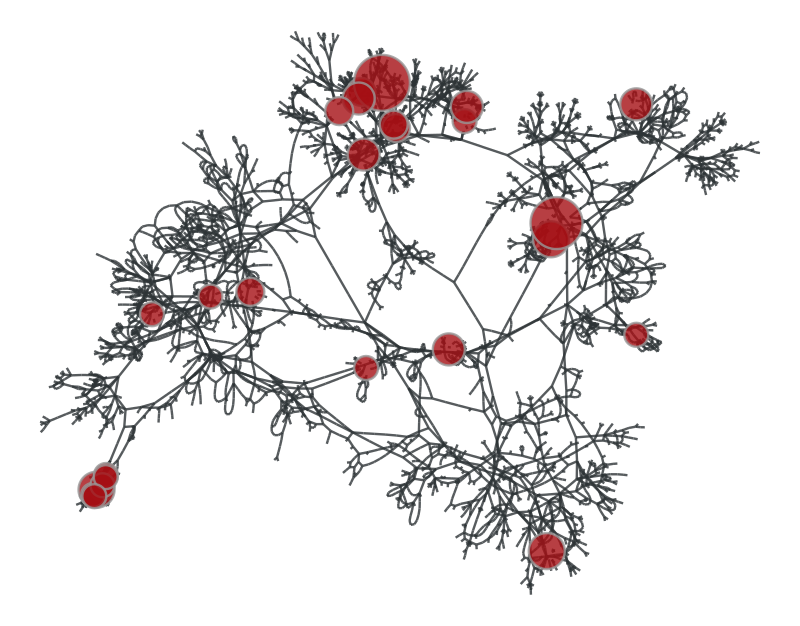

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1062f14d0, at 0x1063053d0>

In [3]:
# TODO

# Create a property map for the size of the vertices
vertex_size = g.new_vertex_property('int')
position = g.vertex_properties['pos']

# Set the vertex size property map so that nodes with many connections 
# have a larger size of vertex
for v in g.vertices():
    if (v.in_degree() + v.out_degree()) > 10:
        vertex_size[v] = (v.in_degree() + v.out_degree() - 5) * 2
    else:
        vertex_size[v] = 0

gt.graph_draw(g, pos=position, vertex_size=vertex_size, output_size=(400, 400), edge_pen_width=1.2, vertex_pen_width=1.2)

**Task 1b:** Identify one of the centrality measures that can be used to indicate powerlines that act as a bridge between different parts of the network. Use this to emphasize structurally important nodes and powerlines.

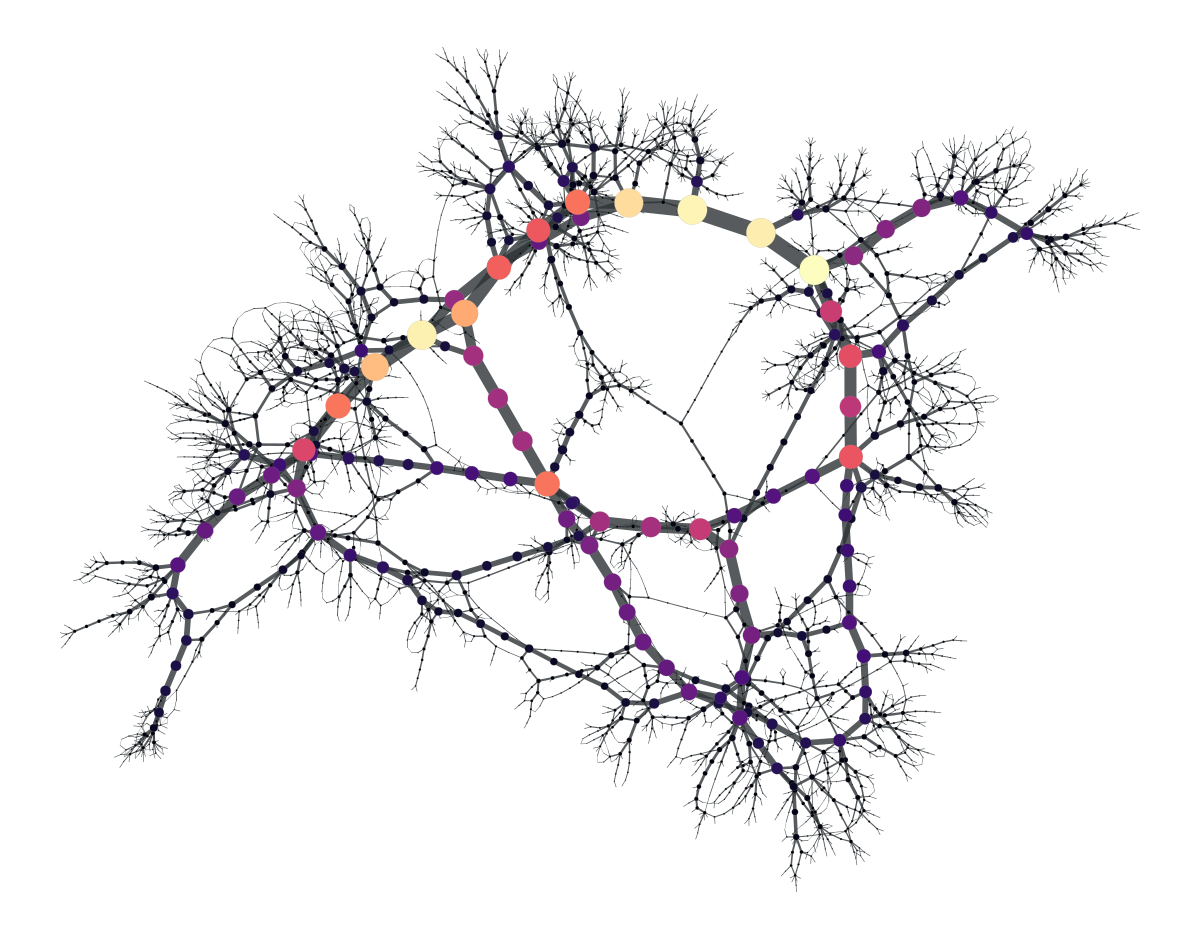

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1062f14d0, at 0x176d94290>

In [4]:
# TODO

vb, eb = gt.betweenness(g)     # Returns property maps for vertex betweenness values and edge betweenness values
gt.graph_draw(g, 
            pos=g.vp['pos'],
            vertex_fill_color=vb,
            vertex_size=gt.prop_to_size(vb, mi=0, ma=15),
            vorder=vb,
            edge_pen_width=gt.prop_to_size(eb, mi=0, ma=8))


# Problem 2: Small social graph visualization

In [5]:
X_knows = {
    'Mary': ['Peter', 'Albert', 'DavidF', 'Peter'],
    'Judy': ['Bob', 'Alan'],
    'Peter': ['Mary', 'DavidF', 'Jon'],
    'DavidF': ['Albert', 'Joseph', 'Peter', 'Mary'],
    'Jon': ['Peter', 'Joseph', 'DavidE'],
    'DavidE': ['Jon', 'Joseph', 'Albert'],
    'Joseph': ['DavidE', 'Jon', 'DavidF'],
    'Bob': ['Judy', 'Alan'],
    'Alan': ['Bob', 'Mary', 'Judy'],
    'Albert': ['DavidF', 'Mary', 'DavidE'],
}

**Task**: Create an undirected graph that represents the personal network above, remove parallel edges, and draw using a layout that resembles the tidy example as shown further below.

In [6]:
# TODO adjust the code below and add to it

g = gt.Graph(directed=False) # graph should be undirected
v_name = g.add_edge_list(((n,k) for n in X_knows for k in X_knows[n]),
                         hashed=True)
pos = gt.random_layout(g)
au.rotate_layout(pos, "Alan", "Mary", v_name)

In [7]:
# Remove the parallel edges
gt.remove_parallel_edges(g)

In [8]:
# TODO find suitable vertex properties for graph_draw (see gt reference docs)
vprops = {'text': v_name,
          'font_size': 12,
          }

# Create a more reasonable layout
pos = gt.sfdp_layout(g)

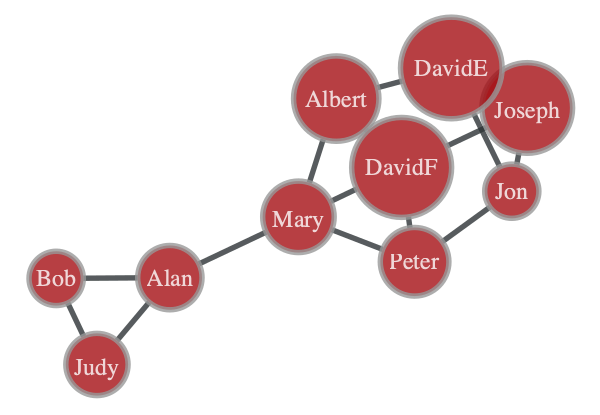

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x177eb6750, at 0x177f19090>

In [9]:
gt.graph_draw(
    g,
    pos=pos,
    vprops=vprops,
    output_size=(300,300), # adjust to fit screen
    fit_view=.9,
    fmt="png"
)

After adjusting the code above you should be able to obtain a 'tidy' result like this.
![](graph.svg)

# Problem 3: Facebook graph analysis

For this question we will work with a real social graph of facebook friendship connections. Please download [`facebook_combined.txt` from SNAP](https://snap.stanford.edu/data/ego-Facebook.html), the Stanford Large Network Dataset Collection and create a `Graph` object with `graph-tool`. The dataset contains the ego networks of 10 facebook users, i.e. it contains the ego nodes, the friends of each of these facebook users, and the connections among those friends.

Goal below is to determine influencers among the users, based on a measure of centrality and not including the ego nodes themselves.

**Task 3a:** Load the dataset and create a drawing of the graph.

In [10]:
# TODO

# Create a graph
g = gt.Graph(directed=False)
file_path = '/Users/michaelkuby/Documents/GitHub - Local/CMPT733_DataScience/A7/facebook_combined.txt'

# For reach line in the graph, make a dict of vertices (sources) and connections (friends)
X_knows = {}

with open(file_path, 'r') as file:
    for line in file:
        src, friend = line.strip().split()
        src, friend = int(src), int(friend)

        if src not in X_knows:
            X_knows[src] = [friend]
        else:
            X_knows[src].append(friend)

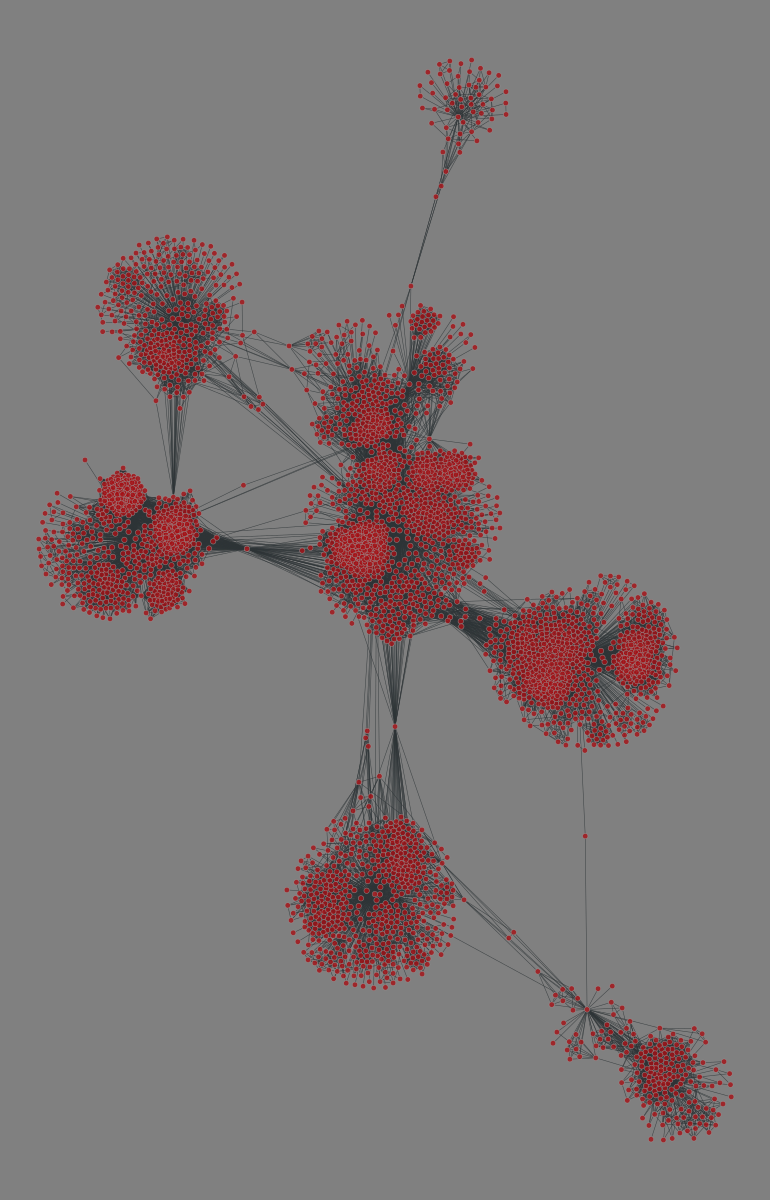

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x177ec58d0, at 0x174c8b250>

In [11]:
# Add the edges to the graph and return a vprop
v_name = g.add_edge_list(((n,k) for n in X_knows for k in X_knows[n]))

# Create a more reasonable layout
pos = gt.sfdp_layout(g)

# Draw the graph
gt.graph_draw(
    g,
    pos=pos,
    bg_color=[0.5, 0.5, 0.5, 1],
    output_size=(600,600), # adjust to fit screen
    fit_view=.9,
    fmt="png"
)

**Task 3b:** Calculate and show a histogram of pairwise distances among users. Internally, this distance would be computed for the shortest path of connections among any pair of users.

Use a log-scale of the frequencies to scale the histogram bars.

What is the diameter of this graph?

*Hint:* Calculating and drawing the histograms amounts to two lines of code using `gt` and `plt` modules.

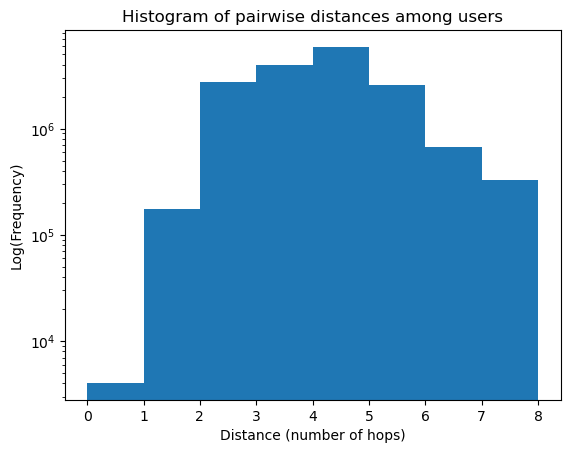

In [12]:
# TODO

# Calculate and show a histogram of pairwise distances among users, using gt and plt modules
# Calculate the distances
all_distances = gt.shortest_distance(g)
distance_array = all_distances.get_2d_array(range(g.num_vertices()))
flat_distances = distance_array.flatten()

# Use a log-scale of the frequences to scale the histogram
plt.hist(flat_distances, bins=8, log=True)

# Set the labels and title
plt.xlabel('Distance (number of hops)')
plt.ylabel('Log(Frequency)')
plt.title('Histogram of pairwise distances among users')
plt.show()

**Task 3c:** Determine influencers, i.e. people withing the ego network that are well connected among friends.

There are several steps to this analysis. First, remove the ego nodes. You can do this in an approximate way, simply by calculating a measure of influence of a user and removing the highest scoring nodes, assuming that these naturally are the ego nodes whose friends this network consists of.

Use `PageRank` as a measure of influence of a node.

*Step 1* - Create a drawing of a GraphView that only retains nodes with a `pagerank` $< 0.002$.

In [13]:
# TODO
pr = gt.pagerank(g)
gv = gt.GraphView(g, vfilt=pr.a < 0.002)

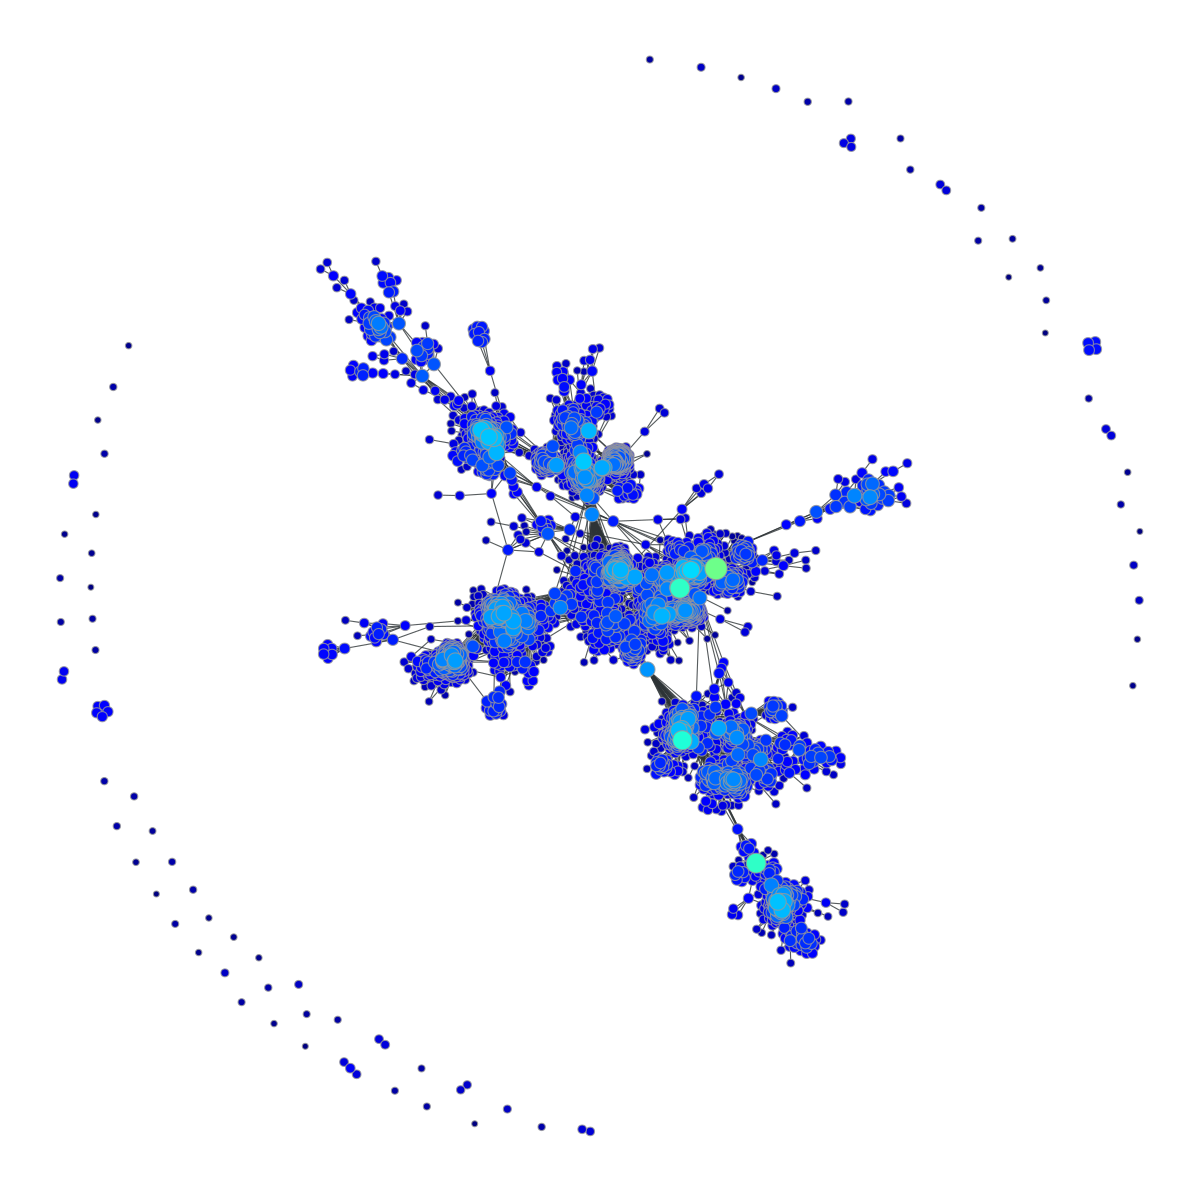

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x174c03050, at 0x2b1958910>

In [14]:
gt.graph_draw(gv,
            vertex_fill_color=gt.prop_to_size(pr),
            vertex_size=gt.prop_to_size(pr, mi=3, ma=20),
            vorder=pr,
            vcmap=plt.cm.jet)

In [15]:
# TODO

*Step 2* - Only retain the largest connected component of this graph, i.e. create another [`GraphView`](https://graph-tool.skewed.de/static/doc/quickstart.html#graph-views) of only this largest component.

In [16]:
# TODO
largest_component = gt.label_largest_component(gv)
gv_largest = gt.GraphView(gv, vfilt=largest_component)   # extract the largest component as a graph

*Step 3* - Recalculate pagerank for each node, choose a threshold (e.g. 0.0005) above which only a small part of the users are selected. Create a drawing that emphasizes these users that play central roles among their friends.

In [17]:
# TODO
pr_largest = gt.pagerank(gv_largest)
gv_largest_filt = gt.GraphView(gv_largest)

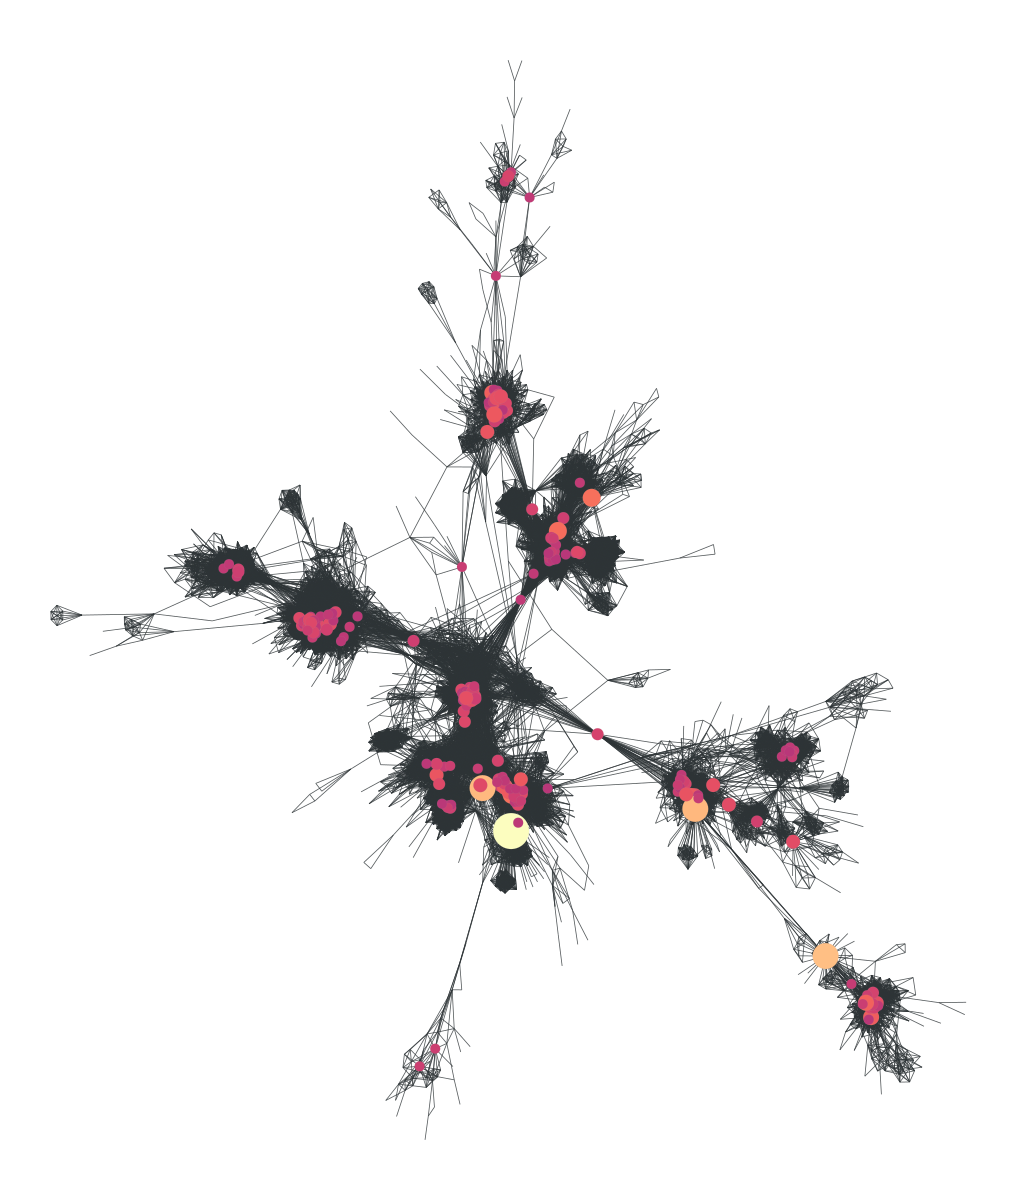

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x174c8b290, at 0x2bc8689d0>

In [19]:
# TODO

# Create a property map for the size of the vertices
vertex_sizes = gv_largest_filt.new_vertex_property('int')

# Set the vertex size property map so that nodes with a with threshold above 0.0005 are larger
for v in gv_largest_filt.vertices():
    if pr_largest[v] > 0.0005:
        vertex_sizes[v] = pr_largest[v] * 10000
    else:
        vertex_sizes[v] = 0

gt.graph_draw(gv_largest_filt, 
              vertex_size=vertex_sizes, 
              output_size=(600, 600), 
              edge_pen_width=.4,
              vertex_fill_color=gt.prop_to_size(pr_largest))

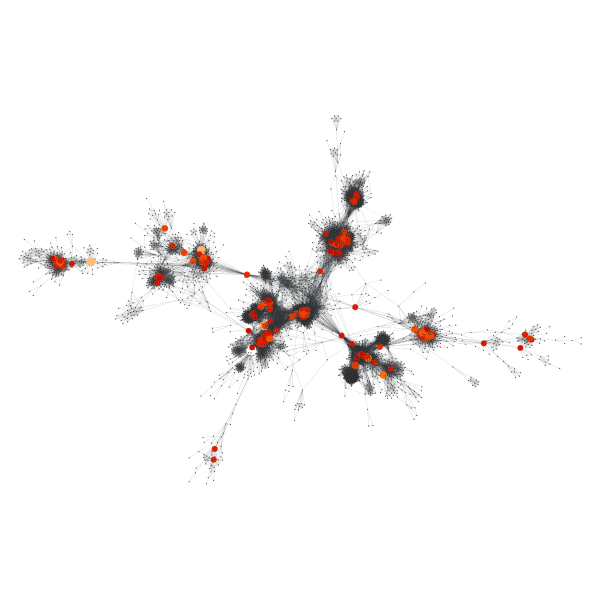

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fc2dc2b76a0, at 0x7fc2a1b70c50>

In [245]:
# TODO

# Environment setup details

[Setup instruction](https://git.skewed.de/count0/graph-tool/-/wikis/installation-instructions#installation-via-package-managers) are available for most environments. To use the setup in the lab, see below.

We have prepared a `conda` environment in the lab that contains all modules required for this assignment. You can activate the environment as follows:

```
conda activate /usr/shared/CMPT/big-data/condaenv/nn11
```

#### You might get an error
`CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.`
This happens, if you have not used conda before. To perform initialization once, we recommend the following steps:
```
cd /usr/shared/CMPT/big-data/miniforge3/bin
./conda init bash
./conda config --set auto_activate_base false
```
If you now restart your terminal shell or simply invoke a new one by typing `bash`, you can try activating the environment, again.

# Submission instructions
Please submit this A7.ipynb notebook
to [CourSys](https://coursys.sfu.ca/2024sp-cmpt-733-g1/+a7/),
filled out with figures included.